In [1]:
import re
from tqdm import tqdm
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
opts = Draw.MolDrawOptions()
opts.legendFraction = 0.2
opts.legendFontSize = 20

## Load the compounds into a list of SMILES strings

In [ ]:
# read tsv file
df = pd.read_csv('inputs/rhea-reaction-smiles.tsv', sep='\t', header=None)
df.head()

,0,1
0,10001,CCCCC(N)=O.[H]O[H]>>CCCCC(=O)[O-].[H][N+]([H])...
1,10002,CCCCC(=O)[O-].[H][N+]([H])([H])[H]>>CCCCC(N)=O...
2,10005,S=C=NCC1=CC=CC=C1>>N#CSCC1=CC=CC=C1
3,10006,N#CSCC1=CC=CC=C1>>S=C=NCC1=CC=CC=C1
4,10009,*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O.*OO>>*N[...


In [4]:
smiles_list = []
reactions = df[1].values
for reaction in tqdm(reactions):
    reaction_smiles_list = re.split(r'>>|\.', reaction)
    for reaction_smiles in reaction_smiles_list:
        smiles_list.append(reaction_smiles)

  0%|          | 0/33312 [00:00<?, ?it/s]

100%|██████████| 33312/33312 [00:00<00:00, 325157.10it/s]


In [5]:
smiles_list = list(set(smiles_list))
len(smiles_list)

12688

## Define Substructure

In [6]:
# Define substructure
substructure_smiles = "C1CCC2CCC3C4CCCC4CCC3C2C1"
substructure = Chem.MolFromSmiles(substructure_smiles)

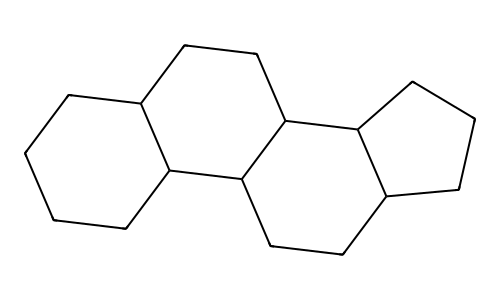

In [7]:
Draw.MolToImage(substructure, size=(500, 300))

## Funtion for substructure search

In [8]:
def modify_molecule(smiles):
    # Convert SMILES to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Remove aromaticity and change all N, O, S atoms to C
        for atom in mol.GetAtoms():
            atom.SetIsAromatic(False)
            if atom.GetSymbol() == 'N' or atom.GetSymbol() == 'O' or atom.GetSymbol() == 'S':
                atom.SetAtomicNum(6)  # Atomic number of Carbon is 6

        # Change all bonds to single bond
        for bond in mol.GetBonds():
            bond.SetIsAromatic(False)
            if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
                bond.SetBondType(Chem.rdchem.BondType.SINGLE)
        
        return mol
    return None

In [9]:
has_substructure_list = []
for smiles in tqdm(smiles_list):
    try:
        modified_smiles = modify_molecule(smiles)
        if modified_smiles is not None:
            result = modified_smiles.HasSubstructMatch(substructure, useChirality=False)
            if result:
                has_substructure_list.append(smiles)
    except:
        continue
len(has_substructure_list), has_substructure_list[:5]

 40%|███▉      | 5041/12688 [00:01<00:01, 3864.52it/s][13:05:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:05:12] WARNING: not removing hydrogen atom with dummy atom neighbors
100%|██████████| 12688/12688 [00:03<00:00, 3866.56it/s]


(800,
 ['[H][C@]12CC[C@]3(C)C(=O)CC[C@@]3([H])[C@]1([H])C(=O)C=C1C[C@@H](O)CC[C@@]12C',
  '[H][C@@]12CC[C@]([H])([C@H](C)/C=C/C(=C)C(C)C)[C@@]1(C)CC[C@@]1([H])/C2=C\\C=C2\\C[C@@H](O)CC[C@@]21C',
  '[H][C@]12CC[C@]3([H])[C@]([H])(CC[C@]4(C)[C@@H](O)CC[C@@]34[H])[C@@]1(C)CC[C@H](O)C2',
  '[H][C@@]12CCC3=C(C=C(O)C(OC)=C3)[C@@]1([H])CC[C@]1(C)C(=O)CC[C@@]21[H]',
  '[H][C@@]12CC(=O)CC[C@]1(C)[C@@]1([H])C[C@H](O)[C@@]3(C)[C@@]([H])(CC[C@]3([H])[C@]([H])(C)CCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](N4C=NC5=C4N=CN=C5N)[C@H](O)[C@@H]3OP(=O)([O-])[O-])[C@]1([H])[C@H](O)C2'])

## Visualize an example processing procedure

In [17]:
mol = Chem.MolFromSmiles(has_substructure_list[212])

# Save initial state
initial_mol = Chem.Mol(mol)
initial_results = mol.HasSubstructMatch(substructure, useChirality=False)

# Modify atom properties
for atom in mol.GetAtoms():
    atom.SetIsAromatic(False)
    if atom.GetSymbol() in {'N', 'O'}:
        atom.SetAtomicNum(6)  # Atomic number of Carbon is 6
intermediate_mol = Chem.Mol(mol)
intermediate_results = mol.HasSubstructMatch(substructure, useChirality=False)

# Modify bond properties
for bond in mol.GetBonds():
    bond.SetIsAromatic(False)
    if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
        bond.SetBondType(Chem.rdchem.BondType.SINGLE)
final_mol = Chem.Mol(mol)
final_results = mol.HasSubstructMatch(substructure, useChirality=False)


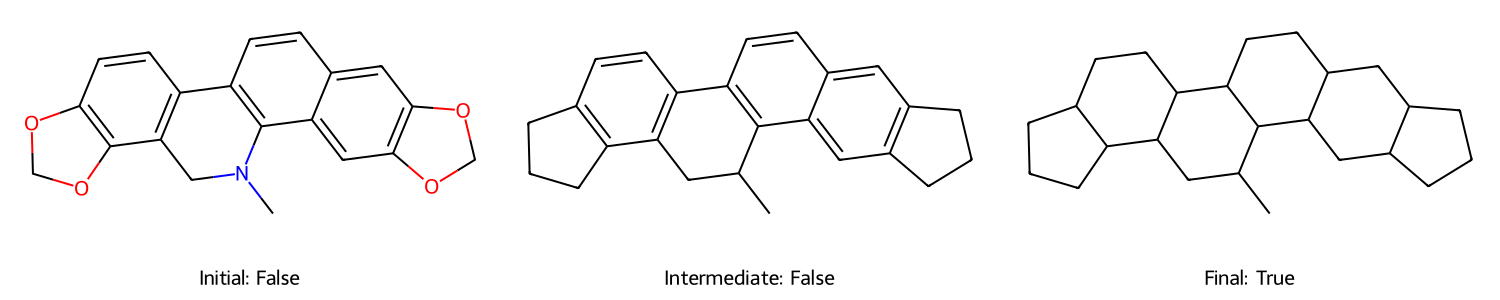

In [18]:
Draw.MolsToGridImage([initial_mol, intermediate_mol, final_mol], molsPerRow=3, subImgSize=(500, 300), legends=['Initial: '+ str(initial_results), 'Intermediate: '+ str(intermediate_results), 'Final: '+ str(final_results)], drawOptions=opts)

## Save the results (all the steroid found in the dataset)

In [12]:
import os

# Create a directory to save the results
if not os.path.exists('results'):
    os.makedirs('results')

In [13]:
# save smiles in txt file
with open('results/rhea_steroids_SMILES.txt', 'w') as f:
    for i in range(len(has_substructure_list)):
        f.write("Compound " + str(i+1) + "  " + has_substructure_list[i] + "\n")

In [ ]:
from PIL import Image
import io

mols = [Chem.MolFromSmiles(smiles) for smiles in has_substructure_list]

# List to hold PIL Image objects for all molecule grids
images = []

# Generate the images for molecules and keep them in memory
for i in range(0, len(mols), 5):
    img = Draw.MolsToGridImage(
        mols[i:i+5], 
        molsPerRow=5, 
        subImgSize=(1000, 1000), # adjust the size of the image based on need!!!
        legends=[f"Compound {j+1}" for j in range(i, min(i+5, len(mols)))],
        drawOptions=opts,
        returnPNG=False
    )
    
    # Save the RDKit image to an in-memory byte stream and convert to PIL Image
    buf = io.BytesIO()
    img.save(buf, format="PNG")  # Save RDKit image as PNG to the buffer
    buf.seek(0)  # Reset buffer pointer to the beginning
    pil_img = Image.open(buf)  # Load as PIL Image
    images.append(pil_img)

# Combine all images into a single PDF in memory
pdf_path = 'results/rhea_steroids.pdf'
images[0].save(pdf_path, save_all=True, append_images=images[1:])

print(f"PDF created at {pdf_path}")

PDF created at results/rhea_steroids.pdf
